In [1]:
from sentinelhub import SHConfig

# In case you put the credentials into the configuration file you can leave this unchanged

CLIENT_ID = 'ec4f50ed-33c6-4e8d-806c-f6ca435c18bd'
CLIENT_SECRET = 'ec4f50ed-33c6-4e8d-806c-f6ca435c18bd'
CLIENT_SECRET = '&E}d~KiDvRmIUmZ>fd+h_TF*mg#:g~[<bPI<ix<E'
config = SHConfig()


if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if config.sh_client_id == '' or config.sh_client_secret == '':
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")
    

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest

def plot_image(image, factor=1.0, clip_range = None, figsize=None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    if figsize:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    else:
        fig, ax = plt.subplots(nrows=1, ncols=1)
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
        return fig, ax
    else:
        ax.imshow(image * factor, **kwargs)
        return fig, ax
    #ax.set_xticks([])
    #ax.set_yticks([])

In [45]:
evalscript_dem = '''
//VERSION=3
function setup() {
  return {
    input: ["DEM"],

    output:{
      id: "default",
      bands: 1,
      sampleType: SampleType.FLOAT32
    }
  }
}

function evaluatePixel(sample) {
  return [sample.DEM]
}
'''

dem_request = SentinelHubRequest(
    evalscript=evalscript_dem,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.DEM,
            time_interval=('2020-06-12', '2020-06-13'),
    )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config
)

dem_data = dem_request.get_data()
#dem_data[0] = dem_data[0].T
data = dem_data[0].T;

In [46]:

from bresenham import bresenham

import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict

#fig_rays, ax_rays = plt.subplots(nrows=1, ncols=1, figsize=(12,8))

def get_rays(center_point, data):
    # m vrstic (y), n stolpcev (x)
    data = data#[:20,:15]
    m, n = data.shape[1], data.shape[0]
    edge_points = list(zip([0 for _ in range(m)], list(range(m)))) + list(zip([n-1 for _ in range(m)], list(range(m)))) + list(zip(list(range(1,n-1)), [0 for _ in range(n-2)])) + list(zip(list(range(1,n-1)), [m-1 for _ in range(n-1)]))

    x,y = list(map(lambda x : x[0], edge_points)), list(map(lambda x : x[1], edge_points))
    #plt.plot(x,y,'o')

    rays = []

    for p in edge_points:
        temp_ray = list(bresenham(center_point[0], center_point[1], p[0], p[1]))
        # dodamo podatek o višini
        ray = OrderedDict()
        for t in temp_ray[:-1]:
            ray[t] = (data[t[0],t[1]])
        rays.append(ray)

    print(len(rays))
    '''for i in range(0,len(rays),30):
        ray = rays[i].keys()
        x,y = list(map(lambda x : x[0], ray)), list(map(lambda x : x[1], ray))
        plt.plot(x,y,color='y')

    plt.show()'''
    return rays

m, n = data.shape[1], data.shape[0]
center_point = (n//2,m//2)
rays = get_rays(center_point, data)
#[(-1, -4), (0, -3), (0, -2), (1, -1), (2, 0), (2, 1), (3, 2)]

5264


In [47]:
def is_left(p1, p2, p3):
    p1, p2, p3 = list(map(np.array, [p1, p2, p3]))
    #print(p1)
    return np.cross(p3 - p1, p2 - p1) <= 0


def seeable_points_on_ray(ray, altitudes):
    start = (0,altitudes[0])
    middle = (1,altitudes[1])
    
    final_ray = {}
    # našo in prvo točko, ki ni naša, vedno vidimo
    final_ray[ray[0]] = 1
    final_ray[ray[1]] = 1
    
    for i in range(2,len(ray)):
        #print(start,middle,(ray[i],i))
        if is_left(start,middle,(i,altitudes[i])):
            middle = (i,altitudes[i])
            final_ray[ray[i]] = 1
        else:
            final_ray[ray[i]] = 0
    
    return final_ray

In [48]:
def dist(a,b):
    d = np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)
    
    return 

In [27]:
betsiboka_coords_wgs84 = [13.430786,45.565987,15.548401,46.464349]

resolution = 100
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {betsiboka_size} pixels')

Image shape at 100 m resolution: (1646, 988) pixels


In [50]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=('2020-04-01', '2020-08-30'),
            mosaicking_order='leastCC'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config
)

true_color_imgs = request_true_color.get_data()
image = true_color_imgs[0]
print(f'Image type: {image.dtype}')

Image type: uint8


5264


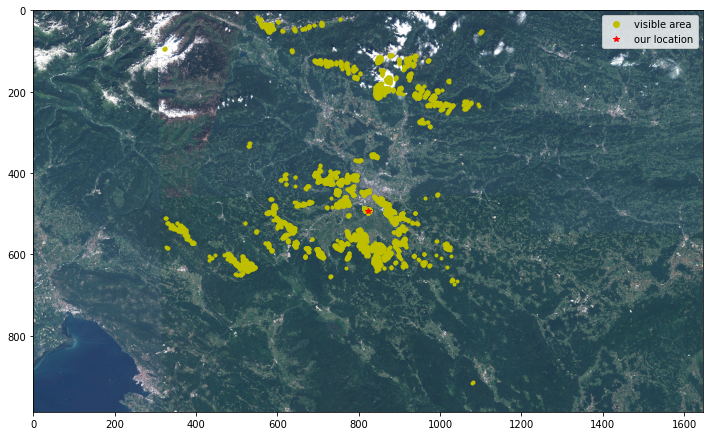

In [51]:
import random

figsize = (12,8)
#fig, ax = plot_image(dem_data[0].T, factor=1.0, cmap=plt.cm.Greys_r, vmin=np.amin(dem_data[0]), vmax=np.amax(dem_data[0]), figsize=figsize)
fig, ax = plot_image(image, factor=0.017, clip_range=(0,1), figsize=figsize)
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
#ax.axis([0, data.shape[0], 0, data.shape[1]-1])

ax.set_ylim(data.shape[1]-1, 0)
print(len(rays))
p1 = None
for ray in rays:
    if random.random() < 0.1:
        see_ray = seeable_points_on_ray(list(ray.keys()), list(ray.values()))
        #print(see_ray)
        for p in see_ray:
            if see_ray[p] == 1:
                p1 = p
                #seeable.add((p[0],p[1]))
                plt.plot(p[0],p[1],'o', color='y', alpha=1, markersize=3)
plt.plot(p1[0],p1[1],'o', color='y', alpha=1, label="visible area")
#x_seeable, y_seeable = list(map(lambda x : x[0], seeable)), list(map(lambda x : x[1], seeable))
#plt.plot(x[:5],y[:5],'o', color='b')
plt.plot(center_point[0], center_point[1], '*', color='r', label="our location")
ax.legend()
plt.show()


#seeable_points(z)

In [56]:
#plt.savefig("fina.png")